In [2]:
from tensorflow.keras.layers import Dense, Input, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

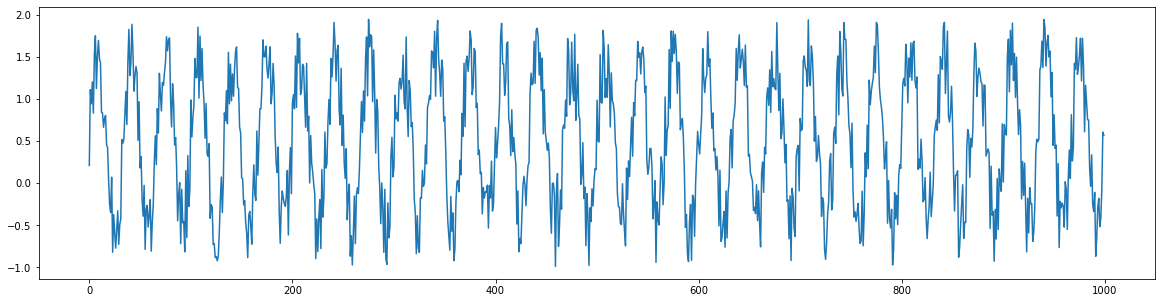

In [16]:
# 2차원 배열의 feature 데이터로 RNN 학습 데이터를 만든다.
def build_train_data(data, t_step, n_jump = 1):
    n_data = data.shape[0]   # number of data
    n_feat = data.shape[1]   # number of features

    m = np.arange(0, n_data - t_step, n_jump)   # m =  [0, 1, 2, 3, 4, 5]
    x = np.array([data[i:(i+t_step), :] for i in m])      # feature data
    y = np.array([data[i, :] for i in (m + t_step)])      # target data

    # shape을 조정한다. feature = 3D, target = 2D
    x_data = x.reshape(-1, t_step, n_feat)
    y_target = y.reshape(-1, n_feat)
    
    return x_data, y_target

# 시계열 데이터 (noisy sin)
n_data = 1000
sine = np.sin(2 * np.pi * 0.03 * np.arange(n_data)) + np.random.random(n_data) # noisy sine
plt.figure(figsize=(20, 5))
plt.plot(sine);

In [5]:
# 데이터가 데이터프레임 형식으로 되어 있다고 생각하자. feature가 1개이고 target이 없는 데이터임.
df = pd.DataFrame({'sine':sine})
df.head()

,sine
0,0.530734
1,0.360580
2,1.178934
3,0.910576
4,1.257445


In [6]:
t_step = 20

# 학습 데이터를 생성한다.
data = np.array(df)
x_train, y_train = build_train_data(data, t_step)
x_train.shape, y_train.shape

((980, 20, 1), (980, 1))

In [7]:
n_input = 1
n_output = 1
n_hidden = 50

# RNN 모델을 생성한다.
x_input = Input(batch_shape=(None, t_step, n_input))
x_rnn = SimpleRNN(n_hidden)(x_input)
y_output = Dense(n_output)(x_rnn)

model = Model(x_input, y_output)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
model.summary(line_length=120)

Model: "model_1"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_2 (InputLayer)                                 [(None, 20, 1)]                                 0                 
                                                                                                                        
 simple_rnn_1 (SimpleRNN)                             (None, 50)                                      2600              
                                                                                                                        
 dense_1 (Dense)                                      (None, 1)                                       51                
                                                                                                                        
Total params: 2

Epoch 1/20
10/10 [==============================] - 1s 27ms/step - loss: 0.6226
Epoch 2/20
10/10 [==============================] - 0s 27ms/step - loss: 0.2000
Epoch 3/20
10/10 [==============================] - 0s 27ms/step - loss: 0.1425
Epoch 4/20
10/10 [==============================] - 0s 27ms/step - loss: 0.1216
Epoch 5/20
10/10 [==============================] - 0s 28ms/step - loss: 0.1138
Epoch 6/20
10/10 [==============================] - 0s 27ms/step - loss: 0.1060
Epoch 7/20
10/10 [==============================] - 0s 26ms/step - loss: 0.1010
Epoch 8/20
10/10 [==============================] - 0s 30ms/step - loss: 0.0988
Epoch 9/20
10/10 [==============================] - 0s 28ms/step - loss: 0.0966
Epoch 10/20
10/10 [==============================] - 0s 28ms/step - loss: 0.0947
Epoch 11/20
10/10 [==============================] - 0s 26ms/step - loss: 0.0928
Epoch 12/20
10/10 [==============================] - 0s 26ms/step - loss: 0.0926
Epoch 13/20
10/10 [==================

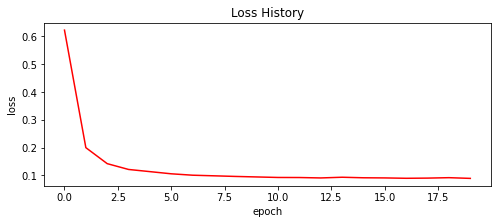

In [8]:
# 학습한다
h = model.fit(x_train, y_train, epochs=20, batch_size=100, shuffle=True)

# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

1/1 [==============================] - 0s 19ms/step


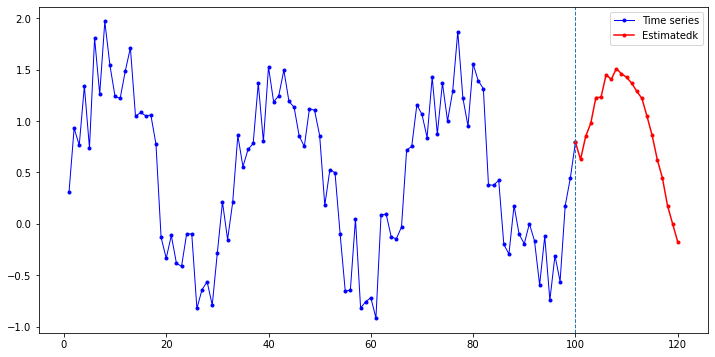

In [19]:
# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.
# 이런 방식으로 20 기간까지 예측한다.
n_future = 20
n_last = 100
last_data = data[-n_last:]  # 원 데이터의 마지막 n_last개만 그려본다

for i in range(n_future):
    # 마지막 t_step 만큼 입력데이터로 다음 값을 예측한다
    px = last_data[-t_step:, :].reshape(1, t_step, 1)

    # 다음 값을 예측한다.
    y_hat = model.predict(px)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    last_data = np.vstack([last_data, y_hat])

past_data = last_data[:-n_future, :]
future_data = last_data[-(n_future + 1):, :]

last_data.shape, past_data.shape, future_data.shape

# 원 시계열과 예측된 시계열을 그린다
plt.figure(figsize=(12, 6))
ax1 = np.arange(1, len(past_data) + 1)
ax2 = np.arange(len(past_data), len(past_data) + len(future_data))
plt.plot(ax1, past_data, '-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(ax2, future_data, '-o', color='red', markersize=3, label='Estimatedk')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()